In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Overview

I'm a huge Lego fan with a Lego town in my basement and a large collection of Lego sets and bricks.  This drove me to search out a Lego data set for a Neural Network model.  Leading me to find this data set on Kaggle: https://www.kaggle.com/datasets/pacogarciam3/lego-brick-sorting-image-recognition/data?select=Cropped+Images.

The goal is to build a CNN model that takes a picture of Lego piece and identifies what piece it is.  The data set contains 4580 total pictures.  These are of 1 of 20 different Lego pieces.  So, this will be classification problem with 20 categories.  

The overall flow of this notebook will be to import required python packages and the Lego image data set.  Then it will do a quick EDA.  Followed by preparing the data for modeling, noteably creating the train, validation, test split and preparing the images to be modeled.  Then we will train the model and evaluate it on the validation set to the model isn't overfitting.  Closing out with test split evaluation and conclusion.



### Import Python packages

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras
from keras import layers
from keras import ops

import PIL
import shutil
import zipfile
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### Import Lego images
Only importing the cropped images, since it appears the cropped images are cropped versions of the base images.  Meaning it would effectively be duplicating the images, if both sets of images were used.  Driving the decision to pick one set of images for modeling.

In [3]:
cropped_path = '../input/lego-brick-sorting-image-recognition/Cropped Images'
##base_path = '/kaggle/input/lego-brick-sorting-image-recognition/Base Images'

In [4]:
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [5]:
lego_jpg = image_path(cropped_path) ##+ image_path(base_path)
print('Number of files in directory: ' + str(len(lego_jpg)))

Number of files in directory: 4580


In [6]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

### EDA


In [7]:
def display(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

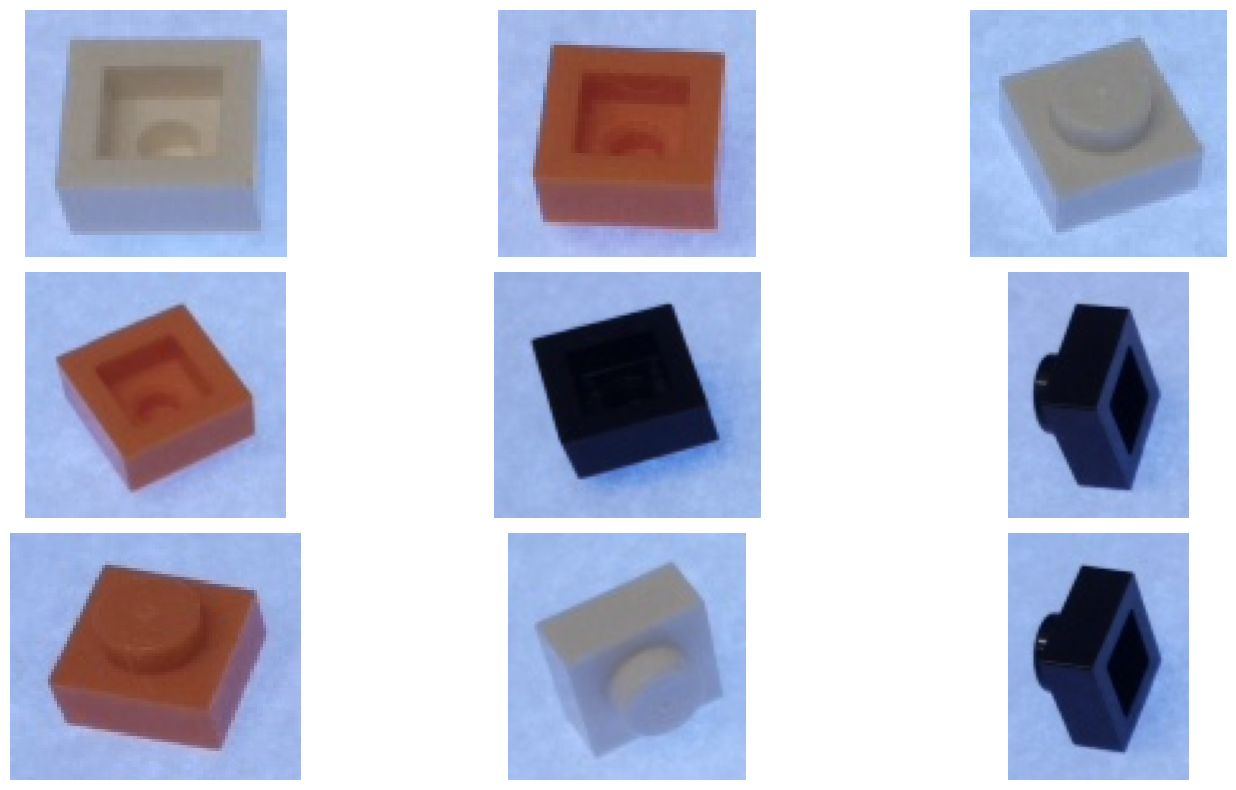

In [8]:
display(lego_jpg, 3, 3)

In [9]:
print('Number of files in directory: ' + str(len(lego_jpg)))

Number of files in directory: 4580


In [10]:
df = pd.read_csv('../input/lego-brick-sorting-image-recognition/ImageSetKey.csv')
df = df[df['Folder1'] == 'Cropped Images']
df['img_path'] = df['Folder2'] + '/' + df['Name']
df.head()

,Folder1,Folder2,Name,Brick Type,img_path
0,Cropped Images,Brick_1x1,1_Brick_1x1_180708133346.jpg,Brick 1x1,Brick_1x1/1_Brick_1x1_180708133346.jpg
1,Cropped Images,Brick_1x1,1_Brick_1x1_180708133400.jpg,Brick 1x1,Brick_1x1/1_Brick_1x1_180708133400.jpg
2,Cropped Images,Brick_1x1,1_Brick_1x1_180708133725.jpg,Brick 1x1,Brick_1x1/1_Brick_1x1_180708133725.jpg
3,Cropped Images,Brick_1x1,1_Brick_1x1_180708133739.jpg,Brick 1x1,Brick_1x1/1_Brick_1x1_180708133739.jpg
4,Cropped Images,Brick_1x1,1_Brick_1x1_180708133753.jpg,Brick 1x1,Brick_1x1/1_Brick_1x1_180708133753.jpg


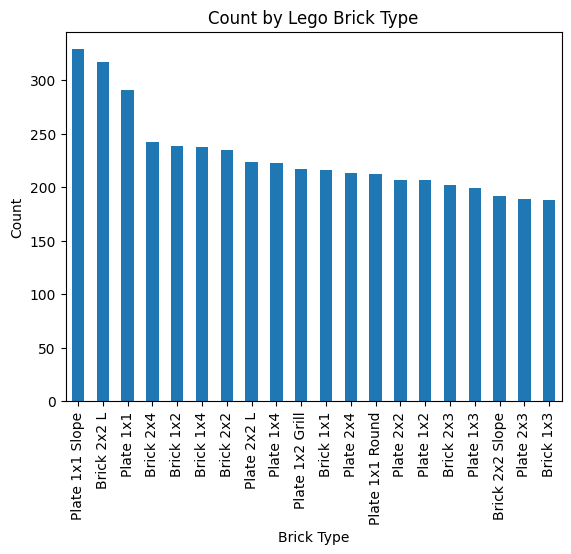

In [11]:
df['Brick Type'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Count by Lego Brick Type')
plt.show()

### EDA Conclusion
This is data set is on the smaller side with only 4580 pictures to identify.  The pictures appear to be pretty well distributed across the 20 diffent Lego elements.  The Lego element pictures are taken from varied angles.  This could be helpful in more real world identificaition settings where you might see the top, side or bottom of it.

### Model Preperation
Plan to separate the data into 3 categories (training, validation, test) with a 70, 15, 15 split.  Then prepare the images for modeling using a grey scale for each of the 3 groups.  

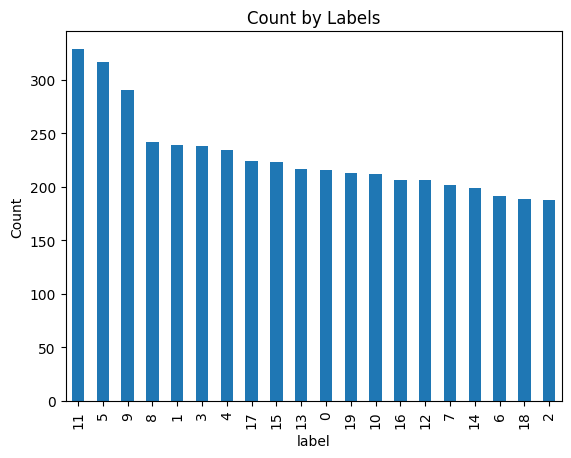

In [12]:
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['Brick Type'])
df['label'] = df['label'].astype(str)
df['label'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Count by Labels')
plt.show()

In [13]:
#Split the data into three groups for training, validation, and test, since this isn't a Kaggle competition with a test data set
#x_train, x_val = train_test_split(df, test_size=0.2, random_state=25)

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 75% of the entire data set
x_train, x_test = train_test_split(df, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(x_train))
print(len(x_test))
print(len(x_val))

3205
688
687


In [16]:
data_gen = ImageDataGenerator(rescale = float(1/255), vertical_flip = True, horizontal_flip = True, rotation_range = 10, zoom_range = 0.1, height_shift_range = 0.1, width_shift_range = 0.1)

In [17]:
gen_train = data_gen.flow_from_dataframe(dataframe = x_train, directory = '../input/lego-brick-sorting-image-recognition/Cropped Images/', x_col = "img_path", y_col = "label", batch_size = 32, seed = 25, shuffle = False, class_mode = 'categorical',color_mode='grayscale', target_size = (256, 256))
gen_val = data_gen.flow_from_dataframe(dataframe = x_val, directory = '../input/lego-brick-sorting-image-recognition/Cropped Images/', x_col = 'img_path', y_col = 'label', batch_size = 32, seed = 25, shuffle = False, class_mode = 'categorical',color_mode='grayscale', target_size = (256, 256))
gen_test = data_gen.flow_from_dataframe(dataframe = x_test, directory = '../input/lego-brick-sorting-image-recognition/Cropped Images/', x_col = 'img_path', y_col = 'label', batch_size = 32, seed = 25, shuffle = False, class_mode = 'categorical',color_mode='grayscale', target_size = (256, 256))

Found 3205 validated image filenames belonging to 20 classes.
Found 687 validated image filenames belonging to 20 classes.
Found 688 validated image filenames belonging to 20 classes.


### Modelling
Set up a CNN model.  The activition funcion for each layer will be leaky relu, which worked better than relu.  This makes sense as some of the Lego piece pictures are at an angle.  The final activation function is a softmax, since it is a multi-class classification problem.  

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='leaky_relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='leaky_relu'))
model.add(Dense(20, activation='softmax'))

optimizer = Adam(learning_rate=0.001, beta_1=0.8, beta_2=0.9)
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │        10,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,088,724 (99.52 MB)

 Trainable params: 26,088,724 (99.52 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hist = model.fit(gen_train, epochs=50, validation_data=gen_val)

Epoch 1/50
 82/101 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - acc: 0.0750 - loss: 3.2767

I0000 00:00:1728090752.984074     108 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 72 bytes spill stores, 72 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - acc: 0.0801 - loss: 3.2190 - val_acc: 0.1368 - val_loss: 2.8066
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - acc: 0.1750 - loss: 2.6310 - val_acc: 0.2504 - val_loss: 2.3967
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - acc: 0.2691 - loss: 2.2881 - val_acc: 0.3377 - val_loss: 2.0430
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - acc: 0.3552 - loss: 1.9660 - val_acc: 0.3333 - val_loss: 1.9527
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 230ms/step - acc: 0.4105 - loss: 1.7745 - val_acc: 0.4629 - val_loss: 1.5656
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - acc: 0.4918 - loss: 1.5197 - val_acc: 0.5328 - val_loss: 1.3702
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - acc: 0.5315 - loss: 1.3747 - val_acc: 0.5429 - val_loss: 1.3874
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - acc: 0.5825 - loss: 1.2307 - val_acc: 0.6463 - val_loss: 1.0396
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s

In [27]:
hist = pd.DataFrame(hist.history)
hist.head(5)

,acc,loss,val_acc,val_loss
0,0.107020,2.962062,0.136827,2.806601
1,0.195944,2.557275,0.250364,2.396668
2,0.288300,2.232083,0.337700,2.042951
3,0.382215,1.904210,0.333333,1.952732
4,0.437441,1.690113,0.462882,1.565561


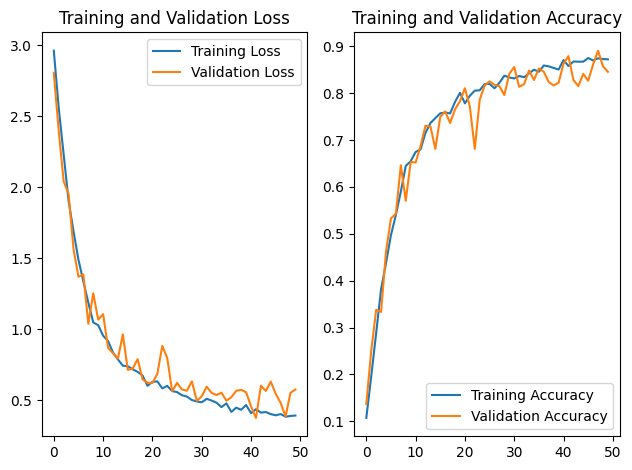

In [28]:
#check for overfitting

#Plot the loss metric
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(hist['acc'], label='Training Accuracy')
plt.plot(hist['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

Evaluated a few different versions of the model, including different learning rates (0.0009, 0.001, 0.002), layers (with and without dropouts), and continued to add epochs.  Ultimately, this model with this structures with no dropouts, learning rate of .001 and 50 epochs performs best on this training and validation set.

### Model Evaluation
Evaluate the model on the test data

In [29]:
pred = model.predict(gen_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step


In [30]:
pred

array([[2.0007101e-33, 2.1101567e-27, 8.6044458e-21, ..., 3.1926303e-32,
        2.8501874e-24, 8.1081174e-20],
       [1.3986853e-27, 8.7940641e-17, 3.2595457e-25, ..., 3.5176371e-04,
        9.9952137e-01, 9.0569278e-25],
       [9.7670873e-13, 1.3374804e-02, 7.5354736e-26, ..., 3.9315073e-06,
        5.5682091e-07, 5.5213305e-15],
       ...,
       [6.0220516e-11, 1.6172824e-05, 7.3295497e-21, ..., 1.3483651e-07,
        7.1765982e-08, 1.0602628e-10],
       [4.6109047e-21, 8.2592558e-25, 1.6743387e-09, ..., 1.3058891e-37,
        5.7577716e-35, 7.0570351e-08],
       [5.9185790e-05, 1.0848770e-11, 2.2652179e-03, ..., 2.0069595e-26,
        6.5272582e-28, 4.5736148e-03]], dtype=float32)

In [34]:
test_acc = model.evaluate(gen_test)[1]
print('Test data set mdoel set accuracy: ' + str(test_acc))

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - acc: 0.8663 - loss: 0.5317
Test data set mdoel set accuracy: 0.8735465407371521


### Conclusion
Overall, this model structure works pretty well.  On the test sample it had around an 87% accuracy, while also having similar accuracy on the validation sample.  

This model could be expanded, with training, to identify more than the 20 different Lego bricks in the data set.  That would be a must considering there are over 13k different types of Lego elements for sale on the website (https://www.lego.com/en-us/pick-and-build/pick-a-brick).  Another future expansion opportunity is to have the model identify the different Lego elements in a picture with multiple Lego brick.  This would help with real world pictures that likely have multiple Lego bricks in them.  

### References
- Used similar model structure to my week 3 challenge: https://github.com/rkilgore5/CU5511_week3/blob/main/week3.ipynb

- Utilized learings and code from here on train, validation, splits: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

- Used this Kaggle data set for images and labels: https://www.kaggle.com/datasets/pacogarciam3/lego-brick-sorting-image-recognition/data?select=Cropped+Images.